Importing Libraries

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import pickle

**Image Preprocessing**


Loading Test and Train Data

In [41]:
trainingpath=r"/content/drive/MyDrive/Colab Notebooks/dataset/spiral/training"
testingpath=r"/content/drive/MyDrive/Colab Notebooks/dataset/spiral/testing"

Quantify Image

In [42]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), 
                           cells_per_block=(2, 2),
                           transform_sqrt=True, 
                           block_norm="L1")
    return features

Feature data and associated class labels

In [43]:
def load_split(path):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    
    for imagePath in imagePaths:
        label = imagePath.split(os.path.sep)[-2]
        
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))

        image=cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        
        features = quantify_image(image)

        data.append(features)
        labels.append(label)

    return (np.array(data), np.array(labels))

Load Train Data and Test Data

In [44]:
print("[INFO] loading data...")
(X_train, y_train) = load_split(trainingpath)
(X_test, y_test) = load_split(testingpath)

[INFO] loading data...


In [45]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
print(X_train.shape,y_train.shape)

(72, 12996) (72,)


**Model** **Building**

Training The Model

In [46]:
print("[INFO] training model")
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

[INFO] training model


RandomForestClassifier()

Testing The Model


In [47]:
testingpath=list(paths.list_images(testingpath))
idxs=np.arange(0,len(testingpath))
idxs=np.random.choice(idxs,size=(25,),replace=False)
images=[]

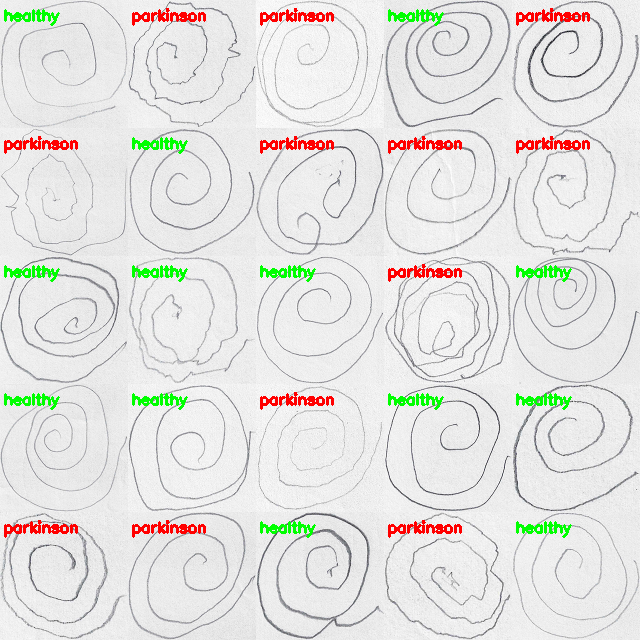

In [48]:
for i in idxs:
    image=cv2.imread(testingpath[i])
    output=image.copy()
        
    # load the input image,convert to grayscale and resize
    
    output=cv2.resize(output,(128,128))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image=cv2.resize(image,(200,200))
    image=cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    #quantify the image and make predictions based on the  extracted feature using last trained random forest
    features=quantify_image(image)
    preds=model.predict([features])
    label=label_encoder.inverse_transform(preds)[0]
    #the set of output images
    if label=="healthy":
        color=(0,255,0)
    else:
        color=(0,0,255)
        
    cv2.putText(output,label,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    images.append(output)

#creating a montage
montage=build_montages(images,(128,128),(5,5))[0]
cv2_imshow(montage)

Model Evaluation

In [49]:
predictions = model.predict(X_test)

cm = confusion_matrix(y_test, predictions).flatten()
print(cm)
(tn, fp, fn, tp) = cm
accuracy = (tp + tn) / float(cm.sum())
print(accuracy)

[13  2  5 10]
0.7666666666666667


Saving The Model

In [50]:
pickle.dump(model,open('parkinson.pkl','wb')) 